<a class="anchor" id="top"></a>
### Predicting bank loan behavior by analyzing bank transactional data with a random forest classifier
Andy Ganse, andy@ganse.org, http://research.ganse.org

The title says it all -- let's implement a random forest classifier from [Scikit-learn](http://scikit-learn.org/stable) to see how well we can predict whether a bank client will have good loan behavior (meaning they won't default or become delinquent) if given a new loan.  In the process we'll review the results validations for this kind of model, and learn about some limitations of Scikit-learn's models.  

Turns out publicly-available bank transaction data is really hard to come by, American or otherwise.  For use below I've found a foreign dataset from the Czech Republic in 1993-1998 - it was a shared dataset for a 1999 European machine learning conference challenge.  This was the PKDD99 Challenge, from the "European Conferences on Machine Learning and European Conferences on Principles and Practice of Knowledge Discovery in Databases ECML/PKDD Discovery Challenges 1999 - 2005 : A Collaborative Effort in Knowledge Discovery from Databases" (whew!).  The dataset is still available on the old conference website (http://sorry.vse.cz/~berka/challenge/PAST) -- scroll down to "PKDD'99 Challenge" on its bottom left.  The dataset description document describing the fields and format is at http://sorry.vse.cz/~berka/challenge/pkdd1999/berka.htm  

These data are anonymized bank transactions covering six years of bank transactions for 5369 bank clients with 4500 accounts (ie some of those clients are coupled on some of the accounts, as for example husbands and wifes).  The currency, the koruna (crown) or CZK, varied in the 25-30/USD range in the 1990s during the dataset.  Exchange rate data and plotted histories are available at https://tradingeconomics.com/czech-republic/currency.  The dataset is not in English, has some funny encoding (eg combining birth-date and gender), and is contained in csv files, so I wrote a simple **module that translates and reorganizes the PKDD99 data into a set of Pandas dataframes all in English; these functions may be of interest to others for convenience in other work -- they're in [`pkd99_bank_data.py`](pkd99_bank_data.py)**.

Some questions to explore below in our modeling of this dataset:
* what are the most important features in the data that are likely to determine poor loan behavior (default and delinquincy)?
* how accurately can we predict the loan behavior given these features?
* is the data's response variable balanaced in terms of frequency of positive and negative occurances, i.e. good loans and bad loans?  Presumably not (hopefully not for the bank's sake!) and in that case does resampling help?


#### Contents:  [Getting the data](#getting)  |  [Creating the features dataframe](#createfeatures)  |  [Classification](#classification)  |  [Next steps](#next)  
<HR>

In [1]:
# the usual iPython boilerplate...
%matplotlib inline
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import datetime
pd.set_option('display.width', 1000)

### Getting the data <a class="anchor" id="getting"></a><small>(return to [top](#top))</small>

Download and unzip the [dataset file](http://sorry.vse.cz/~berka/challenge/pkdd1999/data_berka.zip) from the website mentioned above.  The zip file contains the CSV files listed below (with extension `.asc` for "ASCII" text).  These `.asc` files must be placed in the same directory as this `.ipynb` notebook file before running it:

In [2]:
# checking file sizes, eg note the transactions take approx 70MB
!ls -l *.asc

-rwxr-xr-x@ 1 aganse  staff    155356 Mar 15  1999 account.asc
-rwxr-xr-x@ 1 aganse  staff     31588 Mar 15  1999 card.asc
-rwxr-xr-x@ 1 aganse  staff     94820 Mar 15  1999 client.asc
-rwxr-xr-x@ 1 aganse  staff    129716 Mar 15  1999 disp.asc
-rwxr-xr-x@ 1 aganse  staff      6574 Mar 15  1999 district.asc
-rwxr-xr-x@ 1 aganse  staff     27037 Mar 15  1999 loan.asc
-rwxr-xr-x@ 1 aganse  staff    273800 Mar 15  1999 order.asc
-rwxr-xr-x@ 1 aganse  staff  69406578 Mar 15  1999 trans.asc


Then we use this reader function I wrote to load up and translate and organize the data from those files into some Pandas dataframes:

In [3]:
import pkdd99_bank_data as pkdd99
account,card,client,disp,district,loan,order,trans = pkdd99.get_bank_data()
# note pkdd99.get_bank_data() took ~5min to run on my MBP2015/i7/16GB

These dataframes have metadata of `df.name`, `df.description`, `df.notes` which persist thru the functions in `PKDD99_bank_data` and this notebook, but DO NOT persist thru pickling (ie saving to file and reloading).  This metadata persistance issue has been a recurring discussion in the Python dev community.  I just found this metadata a convenient way to store and reread details about the data, but these details are found in the data description document - so as long as you don't mind losing this internal form of documentation then it's really not a big deal to pickle away.  My own main motivation for saving files was that get_bank_data() took ~5min to run on my MBP/16GB and I didn't want to keep waiting for it while testing.

Again the original [dataset description document](http://sorry.vse.cz/~berka/challenge/pkdd1999/berka.htm) describes the fields and contents, but I've translated and cleaned up the fields and contents in the Pandas dataframes, and their `table_summary()` function lets us see descriptions and the structure of these eight dataframes via top three records.  Think of them as database tables with primary and foreign keys that link the contents across the tables:

In [4]:
# Just outputting a few for sake of space...
#PKDD99.table_summary(account)
#PKDD99.table_summary(card)
#PKDD99.table_summary(disp)
#PKDD99.table_summary(district)
#PKDD99.table_summary(order)
#PKDD99.table_summary(trans)
PKDD99.table_summary(client)
PKDD99.table_summary(loan)
print(loan.codes)

Client : length 5369 : each record describes characteristics of a client
(one client can have one or more accounts)
   client_id date_birth  district_id gender
0          1 1970-12-13           18      F
1          2 1945-02-04            1      M
2          3 1940-10-09            1      F
 
Loan : length 682 : each record describes a loan granted for a given account
(one account may have zero or one loan.  see loan.codes for ABCD status definitions)
   loan_id  account_id       date  amount  duration  payments status
0     5314        1787 1993-07-05   96396        12    8033.0      B
1     5316        1801 1993-07-11  165960        36    4610.0      A
2     6863        9188 1993-07-28  127080        60    2118.0      A
 
Loan status codes:
A = contract finished, no problems
B = contract finished, loan not payed
C = running contract, OK so far
D = running contract, client in debt


Here's the structure of those dataframe relationships:
<img src="structure.png" width="60%">

### Creating the features dataframe <a class="anchor" id="createfeatures"></a><small>(return to [top](#top))</small>
After having explored the dataset a bit I'm ready to create a features/response dataframe keyed on clients, to use in modeling loan behavior.  Honestly I don't yet know whether it's more informative to key on each client vs on each account -- noting that one client can have more than one account, and one account can have more than one client -- in this work I'll just key on each client.  In this preliminary analysis I'll use six of the eight data tables.

First we do SQL-style merging of the data from the different dataframes to create a new client-features dataframe, and check the number of resulting records against what we expect given the lengths of the original tables/dataframes:

In [5]:
# Do SQL-style merge of data from different dataframes to create features dataframe for classification
features = pd.merge(account,disp,on='account_id',how='outer')
features = pd.merge(features,loan,on='account_id',how='left',suffixes=('_acct','_loan')) # sufficies for date
features = pd.merge(features,client,on='client_id',how='outer',suffixes=('_bank','_client')) # suffices for district_id
features = pd.merge(features,card,on='disp_id',how='outer',suffixes=('_disp','_card')) # suffices for type
features.rename(columns = {'date':'date_card'}, inplace=True) # for clarity
print(len(features),'total feature records, ie one for each client')  # should be 5369
features = features[pd.notnull(features['loan_id'])]
print(len(features),'feature records with a loan; some accts repeated due to multiple clients on same acct')  # should be 827
print(len(features['account_id'].unique()),'feature records with a loan and unique account_id')  # should be 682

5369 total feature records, ie one for each client
827 feature records with a loan; some accts repeated due to multiple clients on same acct
682 feature records with a loan and unique account_id


Next we compute features for each client from the transactions data - let's do min/max/mean of the account balance for the cumulative M months before the loan date.  So `min1`, `max1`, and `mean1` are for the month before the loan; `min2`, `max2`, and `mean2` cover both of the two months before the loan (not just the second month before the loan); `min3`, `max3`, and `mean3` cover the three months before the loan.  And so on.

In [6]:
# Append columns of minbalM,maxbalM,meanbalM for the cumulative M months before loan start date.
# (note: technically it's M*30days rather than M months due to varying days/month...)
def addcols_monbalstats(features,trans,M):
    trans_acctdate = pd.merge(trans,features[['account_id','date_loan']],on='account_id',how='inner')
    # drop transactions that took place after the loan date:
    trans_acctdate['datediff'] = trans_acctdate['date_loan'].subtract(trans_acctdate['date'])  # 'date' = trans date
    trans_acctdate.drop(trans_acctdate[trans_acctdate.datediff < datetime.timedelta(0)].index, inplace=True)
    # reduce to transactions with M*30days of the loan date (ie datediff < M*30):
    trans_acctdate.drop(trans_acctdate[trans_acctdate.datediff > datetime.timedelta(M*30)].index, inplace=True)
    #monbalstats = trans_acctdate.groupby('account_id')['balance'].agg(['min','max','mean','count']).reset_index()
    monbalstats = trans_acctdate.groupby('account_id')['balance'].agg(['min','max','mean']).reset_index()
    #monbalstats.rename(columns = {'min':'min'+str(M),'max':'max'+str(M),'mean':'mean'+str(M),'count':'N'+str(M)}, inplace=True)
    monbalstats.rename(columns = {'min':'min'+str(M),'max':'max'+str(M),'mean':'mean'+str(M)}, inplace=True)
    features = pd.merge(features,monbalstats,on='account_id',how='left')
    return features

features = addcols_monbalstats(features,trans,1)
features = addcols_monbalstats(features,trans,2)
features = addcols_monbalstats(features,trans,3)
features = addcols_monbalstats(features,trans,4)
features = addcols_monbalstats(features,trans,5)
features = addcols_monbalstats(features,trans,6)

# Quick verification:
#features[['min1','min2','min3','min4','min5','min6','N1','N2','N3','N4','N5','N6']].head()
# Good, we see that for a given record (client), N increases and mins decrease with number of months, as they should.

Next we must identify our response (target) variable, the loan status.  Let's check the counts of the four possible statuses.  We'll lump together statuses A and C as "good" loan statuses, and B and D as "bad" ones.  In future we might try redoing the classification using only B (default) or D (delinquency) alone as "bad" and see how the model compares.  In any case noticing the counts for each of these statuses, we see that we'll need to consider the issue of balancing the data for the classification.

In [7]:
print(features['status'].value_counts().to_string())
print()
print(loan.codes)

C    493
A    258
D     45
B     31

Loan status codes:
A = contract finished, no problems
B = contract finished, loan not payed
C = running contract, OK so far
D = running contract, client in debt


We now set things up to handle the categorical variables.  First let's convert these binary categorical variables to 0s and 1s:

In [8]:
# Convert response var `status` = {A,B,C,D} to `response` = {0,1} (AC good, BD bad):
features.loc[features['status'].isin(['A','C']),'status'] = 1  # good
features.loc[features['status'].isin(['B','D']),'status'] = 0  # bad
features.rename(columns = {'status':'response'}, inplace=True) # so binary response now

# Convert gender={M,F} to gender={0,1}:
features.loc[features['gender'].isin(['F']),'gender'] = 1
features.loc[features['gender'].isin(['M']),'gender'] = 0

# There are credit card features, but not all clients have cards so these features can be Nan,
# which isn't acceptable in the modeling.  Let's create a `has_card`={0,1} feature, drop the
# date the card was opened, and then below we'll still use the type_card feature in a way
# that avoids NaNs.
features['has_card'] = 0
features.loc[pd.notnull(features['date_card']),'has_card'] = 1
features.drop('date_card', axis=1, inplace=True)  # since hard to avoid the NaN in the dates

The rest of the categorical variables have more than two values (ie cardinality > 2), which brings up an interesting issue.  Pandas actually has a new `categorical` data type but as of this writing `scikit-learn` doesn't use it; it's a long known/debated issue about the effort required to rewrite the relevant code.  But this raises a problem that is especially relevant to tree-based models, such as that we're using below.

A standard solution to encoding multi-valued categorical variables into numerical variables for modeling is "one-hot encoding", ie the single categorical variable gets replaced with a series of binary variables, one for each category.  However, the sparsity of the resulting dataset increases with the number of categories, and in the present dataset we have categorical variables `district_id_bank` and `district_id_client` (neighborhoods of the bank branches and clients' homes) which have 77 categories!  In tree-based models that severe sparsity maps into greatly reduced sensitivity or importance of those variables in the splitting, and those variables will always fall to the bottom of the importance list.  The real solution is to use a modeling framework that can handle categorical variables directly (eg H2O, or R).  But for here I'm going to just drop the `district_` features (perhaps I could justify it as a choice to actively prevent unfair/illegal discrimination between clients).  Technically this issue does affect the other lower-cardinality categorical variables we'll encode too, but not nearly as dramatically; we'll bear this in mind when interpreting the results.

Some relevant links on the issue:
* https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests
* https://github.com/scikit-learn/scikit-learn/pull/3346
* https://medium.com/tech-vision/random-forest-classification-with-h2o-python-for-beginners-b31f6e4ccf3c
* https://github.com/h2oai/h2o-tutorials/blob/master/tutorials/gbm-randomforest/GBM_RandomForest_Example.py

In [9]:
# Use pd.get_dummies() to convert categorical vars to binary columns; then drop the original categorical vars:
catvars = ['stmt_frq','type_disp','type_card']  # 'district_id_bank','district_id_client']
# Perhaps add 'duration' to catvars too?  It's directional but only discrete values {12,24,36,48,60}.
features = pd.concat([features, pd.get_dummies(features[catvars], prefix=catvars)], axis=1)
features.drop(catvars,1,inplace=True)

# dropping district features even though they're not included in catvars:
features.drop(['district_id_bank','district_id_client'],1,inplace=True)

Next we must drop the variables that may meaninglessly confound with the response (eg id/key vars):

In [10]:
# Drop confounding variables
confvars = ['account_id','disp_id','client_id','card_id','loan_id']
features.drop(confvars,1,inplace=True)

Lastly, we must convert the date fields to their equivalent UNIX time - an ordered, integer representation which the model can use:

In [11]:
features.date_acct = features.date_acct.view('int64')
features.date_loan = features.date_loan.view('int64')
features.date_birth = features.date_birth.view('int64')

Great.  Now we have 827 records with a `response` column and 34 feature columns in our dataframe, and we're ready to train and analyze a classifier using them.

In [19]:
features.shape

(827, 35)

### Classification <a class="anchor" id="classification"></a><small>(return to [top](#top))</small>

Now we look at the balance of the `response` variable in the data.  If severely unbalanced (as hopefully it is for real bank data, ie many more good loans than bad), we must do something to address it which may affect the amount of training data.  But the amount of training data limits the complexity of the resulting model and what rules can be gleaned from the data governing client behavior re loans.  So let's quick check that situation about the rows of training data:

In [20]:
# number of account/client pairs (ie feature rows) with a loan_id:
print(len(features),'clients with a loan - one client per feature record')
print()
print('Checking how balanced the loan statuses are for using them as training data:')
print(features['response'].value_counts().to_string())

827 clients with a loan - one client per feature record

Checking how balanced the loan statuses are for using them as training data:
1    751
0     76


So the training data is in fact fairly unbalanced (with a 1:10 ratio), strongly weighted to good loans (again a good thing in reality, although surprisingly high percentage actually).  We'll compare effects of balancing the training data via class-weight balancing (built in to SciKit-Learn's RF classifier), the SMOTE synthetic data producing balancing algorithm via the `imbalanced-learn` package from `contrib.scikit-learn`, undersampling the majority class (with `imbalanced-learn`'s RandomUnderSampler class), and doing no balancing at all.
After that a major question will be to discover which features among the many we have are the most important ones; fortunately Random Forests are good at solving that problem on a relatively small number of data.

Calling my own wrapper encapsulating SciKit-Learn's RandomForestClassifier and scoring methods, and Imbalanced-Learn's resamplers, let's compare effects on multiple shuffled-stratifications.  In all case I use a 33%/67% split for test/train data, stratified so that training and test data retain the same class ratio (approx 1:10) between bad and good loans as is in the full dataset:

In [28]:
import implement_rf
print('Precision Recall    F1    ROCarea  Accuracy  ____ConfusionMatrix____   #trees  rebal        0s/1s        0s/1s')
print('-----------------------------------------------------------------------------------------------------------------')
for i in range(4):
    scores,rc,fimp,roc,clf = implement_rf.implement_sklrf(features, rebal='cwbal', textout_fullsummary=True)
print(' ')
for i in range(4):
    scores,rc,fimp,roc,clf = implement_rf.implement_sklrf(features, rebal='smote', textout_fullsummary=True)
print(' ')
for i in range(4):
    scores,rc,fimp,roc,clf = implement_rf.implement_sklrf(features, rebal='under', textout_fullsummary=True)
print(' ')
for i in range(4):
    scores,rc,fimp,roc,clf = implement_rf.implement_sklrf(features, rebal=None, textout_fullsummary=True)

Precision Recall    F1    ROCarea  Accuracy  ____ConfusionMatrix____   #trees  rebal        0s/1s        0s/1s
-----------------------------------------------------------------------------------------------------------------
Pre=0.93 Rec=1.00 F1=0.96 AUC=0.88 Acc=0.93 TP=248 TN=7   FP=18  FN=0   n=100  cwbal  train:51/503  test:25/248
Pre=0.94 Rec=1.00 F1=0.96 AUC=0.90 Acc=0.93 TP=247 TN=8   FP=17  FN=1   n=100  cwbal  train:51/503  test:25/248
Pre=0.94 Rec=0.99 F1=0.96 AUC=0.90 Acc=0.93 TP=246 TN=9   FP=16  FN=2   n=100  cwbal  train:51/503  test:25/248
Pre=0.94 Rec=1.00 F1=0.96 AUC=0.87 Acc=0.93 TP=247 TN=8   FP=17  FN=1   n=100  cwbal  train:51/503  test:25/248
 
Pre=0.95 Rec=0.94 F1=0.94 AUC=0.83 Acc=0.89 TP=232 TN=12  FP=13  FN=16  n=100  smote  train:503/503  test:25/248
Pre=0.96 Rec=0.95 F1=0.96 AUC=0.89 Acc=0.92 TP=235 TN=16  FP=9   FN=13  n=100  smote  train:503/503  test:25/248
Pre=0.96 Rec=0.97 F1=0.96 AUC=0.94 Acc=0.93 TP=240 TN=15  FP=10  FN=8   n=100  smote  train:503/503

Frankly they all do pretty well; this is the first hint that certain features picked out from the transactions data are very sensitive to the loan behavior.  But it is interesting to note that the class_weight balancing (`cwbal`) had little effect relative to no balancing at all (`None`).  Undersampling the majority class, the most intuitive approach, appears to have degraded performance by most metrics compared to the methods, presumably due to the reduced training data.
SMOTE appears to've allowed greater true negative resolution (due to more negatives in the training data), at the cost of some more false negatives and very slight reduction in true positive rate.  Let's go with the SMOTE balancing for the rest:

Pre=0.96 Rec=0.92 F1=0.94 AUC=0.84 Acc=0.90 TP=229 TN=16  FP=9   FN=19  n=100  smote  train:503/503  test:25/248


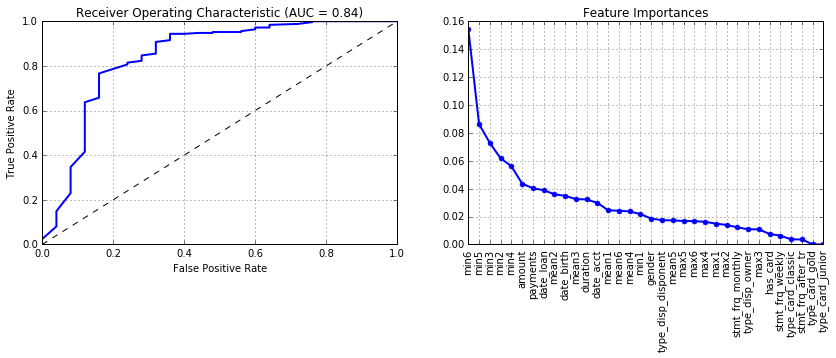

In [22]:
scores,rc,fimp,roc,clf = implement_rf.implement_sklrf(features, rebal='smote', do_plots=True)

So there's what we were after in this work - what's the accuracy of this statistical model and what are the important features?  With imbalanced data, the accuracy is not typically the metric to focus on, but rebalancing remedies that.  The other metrics all show good performance (and repeatably so with every test/train resplit.  What really pops out in rerunning the plots above on different splits is how consistently the minimum balance features remain at the front as the most important model features, which makes sense intuitively.

I do see that many of the categorical variables (max cardinality = 3) that I one-hot-encoded into binary variables have ended up at the bottom of the feature importances, and that brings back to mind the discussion earlier about this.  It's hard to know how much of an issue this is - max cardinality is 3 but these binary variables form 25% of the features.  On the other hand it seems reasonable for things like statement frequency to not be very predictive of loan behavior.  The positioning of those variables is suspicious though, and the likely next issue to resolve in this work.

So we see in the feature importances that minimum balances and some others come into play as important... but how exactly?  We can find that out in looking at a bunch of the individual decision trees from the forest.  (The random forest's result is an average across these trees, so we must look thru many of them.)

In [23]:
implement_rf.create_tree_plots(clf, fimp.fnames, ['bad_loan','good_loan'], N=4, max_depth=1)

<table align="left" width="90%"><tr>
<td width="20%"><img src="tree_0.png"></td>
<td width="20%"><img src="tree_1.png"></td>
<td width="20%"><img src="tree_2.png"></td>
<td width="20%"><img src="tree_3.png"></td>
</tr></table>

The above are only four of the 100 trees, and only the top of the trees for space reasons.  But we can see that it's not simply a matter of trees splitting at zero-balances - rather in scanning over many of these trees they split on "low" balances in the months preceding the loan application.

We can gain some further intuition on the results by exploring histograms of the different features, conditioned on the response variable.  I.e. let's make histograms of the features when response was bad and compare them to histograms of the features when the response was good.

In [24]:
# Convert the date vars back to "datetime" format first so it makes sense in the histograms
features['date_acct'] = pd.to_datetime(features['date_acct'])
features['date_loan'] = pd.to_datetime(features['date_loan'])
features['date_birth'] = pd.to_datetime(features['date_birth'])

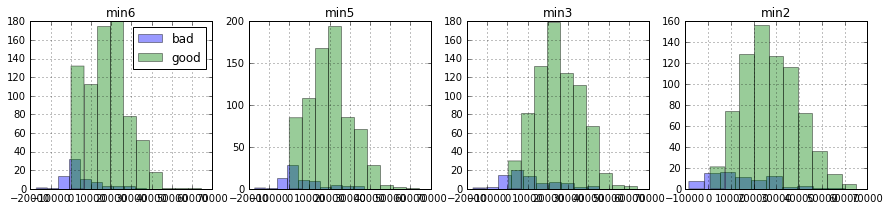

In [25]:
# Plot histograms for the 8 strongest features for good and bad loan cases
tmp = fimp.sort_values(by='fimport',ascending=False)['fnames'][:4]
tmp.loc[-1]='response'
fig, axes = plt.subplots(1, 4, figsize=(15,3))
for i,ax in enumerate(axes.flatten()):
    features[tmp].groupby('response')[tmp.iloc[i]].hist(alpha=0.4,ax=ax)
    ax.set_title(tmp.iloc[i])
    if i==0:
        ax.legend(['bad','good'])

We immediately notice the unbalanced data in these histograms - there's way more "good" loans data (green) than "bad" loans data (lavender).  But aside from that, what is striking in these histograms for the strongest features, is the peak at near-zero balance for the bad loans, which is not seen in the good loans histograms.  In fact the good loans have peaks at much higher balance.

Now for inter-feature relationships (like correlation), just looking at scatter plots...

In [26]:
# (alas scatter plot won't handle datetime types, so we convert back to int again)
features.date_acct = features.date_acct.view('int64')
features.date_loan = features.date_loan.view('int64')
features.date_birth = features.date_birth.view('int64')

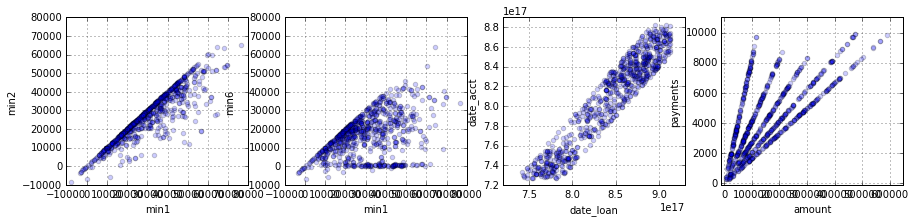

In [27]:
fig, ax = plt.subplots(1,4,figsize=(15,3))
features.plot(kind='scatter',x='min1',y='min2',alpha=0.2,grid=True,ax=ax[0],xlim=(-1e4,8e4),ylim=(-1e4,8e4))
features.plot(kind='scatter',x='min1',y='min6',alpha=0.2,grid=True,ax=ax[1],xlim=(-1e4,8e4),ylim=(-1e4,8e4))
features.plot(kind='scatter',x='date_loan',y='date_acct',alpha=0.2,grid=True,ax=ax[2],xlim=(7.2e17,9.3e17),ylim=(7.2e17,8.9e17))
features.plot(kind='scatter',x='amount',y='payments',alpha=0.2,grid=True,ax=ax[3],xlim=(-1e4,6.5e5),ylim=(-1e2,1.1e4))
plt.show()

Some interesting things I noticed in the scatter plots are (and just plotting these instead of all of them):
* You can see the zero balances pop out in `min5` and `min6` variables, as horizontal or vertical lines within the spread, but not in the `min1` to `min4` features.
* Also in the `min` variables, the diagonal-cutoff form of them validates that `min1 < min2 < min3 < min4 < min5 < min6`.
* The minimum balances are correlated, more so the closer the month spans are to each other (so e.g. note above that min1 vs min2 more closerly correlated than min1 vs min6).
* The band in the histogram for `date_acct` (date account opened) and `date_loan` (date of loan) shows a ~15 month limit on the span between the two dates, presumably caused by an intentional constraint in querying the original data -- ie "extract clients for whom the loan date was no later than ~15 months after the account-opening date -- and perhaps highlights that the original dataset was created with loan themes in mind.
* The monthly `payments` and loan `amount` variables obviously are extremely closely correlated; those five lines in the histogram are the five loan rates corresponding to the five loan durations in the dataset.  Oops - redundant information there that suggests a feature reduction in next version.

### Next steps... <a class="anchor" id="next"></a><small>(return to [top](#top))</small>

* Explore (for bugs/misunderstandings) the pattern I notice that many of the categorical variables went to the bottom of the feature importances - that seems suspicious to me, given the discussion about one-hotted categorical variables in random forests.  If this is found to be something to fix, will that have a significant effect on the conclusions about what the strongest features are?
* Adding in some other features, like district_id_bank and district_id_client, or even all the linked regional/demographic information within the district_id table for those _bank and _client ids.
* Try redoing the classification using only B (default) or D (delinquency) alone as "bad" and see how the model compares.
* A different quantity we could try to predict is whether a client is likely to overdraw based on their earlier transaction history plus all the other features...

#### Website links...
* [over-sampling for unbalanced data](http://contrib.scikit-learn.org/imbalanced-learn/stable/auto_examples/applications/plot_over_sampling_benchmark_lfw.html)
* [imbalanced-learn user guide on contrib.scikit-learn.org](http://contrib.scikit-learn.org/imbalanced-learn/stable/user_guide.html)
* [RF importances](http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py)
* [RF on small datasets](https://stats.stackexchange.com/questions/192310/is-random-forest-suitable-for-very-small-data-sets)  
* [SKL Ensemble methods page, at RF section](http://scikit-learn.org/stable/modules/ensemble.html#forest)
* [SKL Random Forest Classifier API page](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)
* [for ideas about what would benefit customers to experiment with as nudges (but note written by a bank)](https://bettermoneyhabits.bankofamerica.com/en/personal-banking/checking-account-information)